In [1]:
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

## 1. Birth rates

Load the file with detailed stats per name. Each name can be scraped up to four times: a name can exist for both genders and can be a first or follow name.

In [2]:
details = pd.read_json('data/details.json')
names_with_details = details[details.has_details]
print('%i out of %i scraped item contain details (%1.0f%%)' % 
      (len(names_with_details), len(details), 
       len(names_with_details) * 100. / len(details)))

16854 out of 128384 scraped item contain details (13%)


In [3]:
names_with_details[names_with_details.name == 'Anne']

,approximation,first_count,first_percent,follow_count,follow_percent,gender,has_details,name,name_type,step_size,step_total_approximation,step_total_value,value,year
2041,"[5.54, 5.52, 5.63, 22.35, 10.51, 10.49, 25.25,...",29720,0.4005,25792,0.3493,female,True,Anne,first,"[3, 3, 3, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, ...","[18.63, 17.48, 16.39, 22.35, 21.52, 20.32, 25....","[5, 5, 5, 7, 7, 7, 9, 10, 10, 6, 8, 8, 5, 5, 7...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1880, 1881, 1882, 1883, 1884, 1885, 1886, 188..."
38198,"[0.0, 15.02, 15.34, 6.88, 7.08, 7.06, 6.36, 6....",29720,0.4005,25792,0.3493,female,True,Anne,follow,"[0, 2, 2, 3, 3, 3, 3, 3, 3, 7, 7, 7, 7, 7, 7, ...","[0.0, 31.47, 29.51, 22.35, 21.52, 20.32, 19.64...","[0, 9, 9, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1880, 1881, 1882, 1883, 1884, 1885, 1886, 188..."
73886,"[114.97, 109.08, 105.59, 151.97, 149.55, 137.2...",8606,0.1170,8482,0.1196,male,True,Anne,first,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[114.97, 109.08, 105.59, 151.97, 149.55, 137.2...","[33, 34, 34, 50, 52, 50, 59, 54, 64, 57, 65, 7...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1880, 1881, 1882, 1883, 1884, 1885, 1886, 188..."
101921,"[13.41, 13.35, 15.53, 15.2, 14.38, 19.22, 18.8...",8606,0.1170,8482,0.1196,male,True,Anne,follow,"[2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, ...","[27.87, 25.67, 15.53, 15.2, 14.38, 19.22, 18.8...","[8, 8, 5, 5, 5, 7, 7, 9, 11, 11, 20, 20, 11, 8...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1880, 1881, 1882, 1883, 1884, 1885, 1886, 188..."


We're interested in: 
<li> <code>name</code> </li>
<li> <code>gender</code> </li>
<li> <code>name_type</code>: whether it's a first name or a follow name </li>
<li> <code>value</code>: list with # births per year </li>
<li> <code>approximation</code>: list with approximated # births per year </li>
<li> <code>year</code>: array indexing value and approximation </li>

<p>
Unfortunately, value, approximation and year are lists contained in cells in the DataFrame, so we have to do some pandas magic (hidden in the function <code>get_births</code>) to unpack the data.

In [4]:
def get_births(df, id_vars, cols, var_name='ii'):
    """
    Parse scraped data and get birth stats.
    
    :param df: DataFrame with scraped data
    :param id_vars: columns to use as identifiers
    :param cols: columns with values to unpack
    :param var_name: dummy variable name
    :returns DataFrame with unpacked data
    """
    births = pd.concat([convert_and_index(df, id_vars, var_name, p) for p 
                        in cols], axis=1)
    births.reset_index(inplace=True)
    births.drop(var_name, axis=1, inplace=True)
    return births


def convert_and_index(df, id_vars, var_name, value_name):
    """
    Wrapper function for convert_nested_to_long: also sets id_vars
    and var_name as index.
    
    :param df: DataFrame
    :param id_vars: List to use as identified variables
    :param var_name: Name to use for the variable column
    :param value_name: Column name to unpack.
    :returns DataFrame with column data in long format
    """
    converted = convert_nested_to_long(df, id_vars, var_name, value_name)
    return converted.set_index(id_vars + [var_name])


def convert_nested_to_long(df, id_vars, var_name, value_name):
    """
    Convert lists nested in cells in a column to a DataFrame in long
    format.
    
    :param df: DataFrame
    :param id_vars: List to use as identified variables
    :param var_name: Name to use for the variable column
    :param value_name: Column name to unpack.
    :returns DataFrame with column data in long format
    """
    indexed = df.set_index(id_vars)
    unnested = indexed[value_name].apply(pd.Series).reset_index()
    long_format = pd.melt(unnested, id_vars=id_vars, 
                          var_name=var_name, value_name=value_name)
    return long_format

In [5]:
births = get_births(names_with_details, ['name', 'gender', 'name_type'],
                    ['year', 'value', 'approximation'])

The function <code>convert_nested_to_long</code> converts the columns <code>year</code>, <code>value</code> and <code>approximation</code> individually. The lists in the cells of the column are converted to a <code>Series</code>, effectively turning the 1D column with lists into a 2D <code>DataFrame</code>. The data is then transformed from wide to long format by melting the <code>DataFrame</code>. Setting the index with the name, gender and name type preserves these index values during the transformation

In [6]:
temp_name = names_with_details[names_with_details.name == 'Aad']
temp_name.iloc[0]

approximation               [0.0, 0.0, 0.1, 0.1, 0.1, 0.1, 0.11, 0.1, 0.11...
first_count                                                               128
first_percent                                                          0.0017
follow_count                                                              162
follow_percent                                                         0.0023
gender                                                                   male
has_details                                                              True
name                                                                      Aad
name_type                                                               first
step_size                   [0, 0, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66,...
step_total_approximation    [0.0, 0.0, 18.63, 18.24, 17.26, 16.47, 16.14, ...
step_total_value            [0, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...
value                       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [7]:
wide_name = temp_name.set_index(['name', 'gender', 'name_type'])['approximation'].apply(pd.Series)
wide_name

0    1    2    3    4    5     6    7     8     9    \
name gender name_type                                                        
Aad  male   first        0    0  0.1  0.1  0.1  0.1  0.11  0.1  0.11  0.11   
            follow       0    0  0.0  0.0  0.0  0.0  0.00  0.0  0.00  0.00   

                      ...    125   126  127  128  129  130  131  132   133  \
name gender name_type ...                                                    
Aad  male   first     ...   0.41  0.41    0    0    0    0    0    0  0.00   
            follow    ...   0.00  0.00    0    0    0    0    0    0  6.12   

                       134  
name gender name_type       
Aad  male   first        0  
            follow       0  

[2 rows x 135 columns]

In [8]:
pd.melt(wide_name.reset_index(), id_vars=['name', 'gender', 'name_type'], 
        var_name='ii', value_name='approximation').head()

,name,gender,name_type,ii,approximation
0,Aad,male,first,0,0.0
1,Aad,male,follow,0,0.0
2,Aad,male,first,1,0.0
3,Aad,male,follow,1,0.0
4,Aad,male,first,2,0.1


The processsed result looks like:

In [9]:
births.head()

,name,gender,name_type,year,value,approximation
0,Aaf,female,first,1880,0,0.00
1,Aaffien,female,first,1880,0,9.10
2,Aafje,female,first,1880,0,126.69
3,Aafke,female,first,1880,0,115.51
4,Aagje,female,first,1880,0,182.58


Approximate births are given for years that don't have exact data, so we would like to use approximations if no real values are given. 

In [10]:
# Combine approximate & exact stats 
births['n_born'] = births.approximation
has_value = births.value > 0 
births.ix[has_value, 'n_born'] = births.ix[has_value, 'value']
# Tidy up
births.drop(['value', 'approximation'], axis=1, inplace=True)
births['year'] = births['year'].astype(int)
births.rename(columns={'year': 'birth_year'}, inplace=True)

To compute the sums of the births for both name types or both genders, group over the all other identifying columns, and sum the number of births. Append the resulting <code>DataFrame</code> to the original one.

In [11]:
def append_agg(df, id_vars, value_vars, id_name, id_value, aggfunc):
    """
    Append aggregates.
    
    :param df: DataFrame
    :param id_vars: Column(s) to use as identifier variables
    :param value_vars: Column(s) to sum
    :param agg_name: Column to aggregate 
    :param agg_value: Value to use as identifier in aggregated column
    :param aggfunc: Function to use for aggregation
    :returns DataFrame with aggregated sums appended
    """
    if type(aggfunc) is dict:
        totals = df.groupby(id_vars, as_index=False).agg(aggfunc)
    else:
        totals = df.groupby(id_vars, as_index=False)[value_vars].agg(aggfunc)
    totals[id_name] = id_value
    df = df[df[id_name] != id_value].append(totals, ignore_index=True)
    return df

In [12]:
births = append_agg(births, ['name', 'gender', 'birth_year'],
                    'n_born', 'name_type', 'total', 'sum')

The end result looks like:

In [13]:
births.head()

,birth_year,gender,n_born,name,name_type
0,1880,female,0.00,Aaf,first
1,1880,female,9.10,Aaffien,first
2,1880,female,126.69,Aafje,first
3,1880,female,115.51,Aafke,first
4,1880,female,182.58,Aagje,first


In [14]:
births.describe()

,birth_year,n_born
count,3788910.000000,3788910.000000
mean,1947.000000,23.455092
std,38.970079,263.587264
min,1880.000000,0.000000
25%,1913.000000,0.000000
50%,1947.000000,0.560000
75%,1981.000000,4.250000
max,2014.000000,39219.130000


And we can already plot the yearly birth rates for a name:

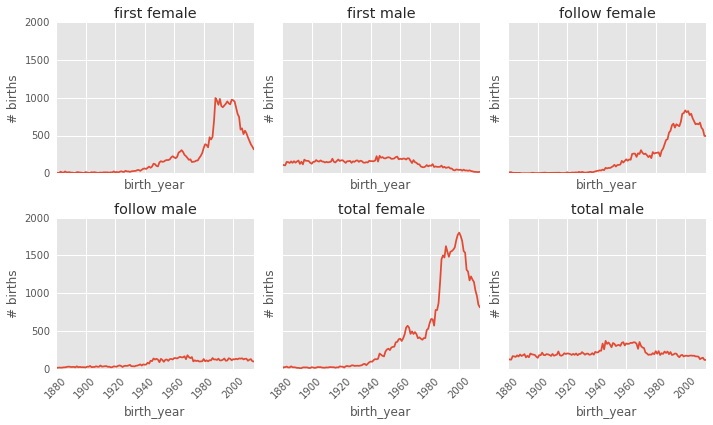

In [15]:
NAME = 'Anne'
id_cols = ['name_type', 'gender']
current_births = births[births.name == NAME]

fig, ax = plt.subplots(2, 3, figsize=(10, 6), sharex=True, sharey=True)
ax = ax.reshape(-1)  # Reshape the list for easy iteraton
for i_plot, (key, group) in enumerate(current_births.groupby(id_cols)):
    group.plot(x='birth_year', y='n_born', ax=ax[i_plot],
               title=' - '.join(key), rot=45)
    ax[i_plot].legend([])
    ax[i_plot].set_ylabel('# births')
fig.tight_layout()

Plotting the yearly birth totals clearly shows a small increase after the First and a big boom after the Second World War.

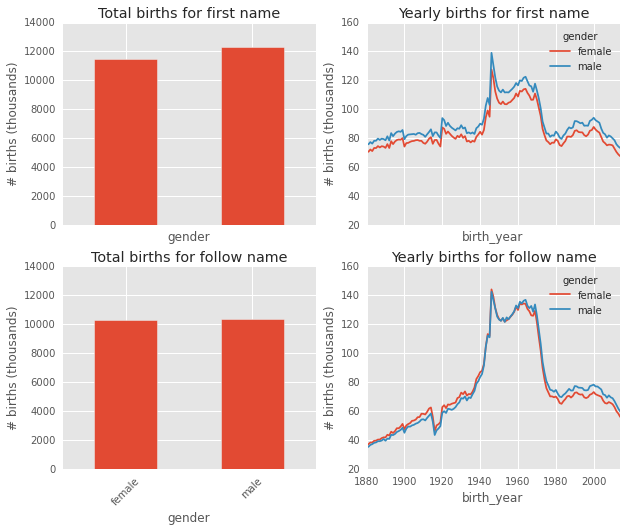

In [16]:
yearly_births = pd.pivot_table(births, index='birth_year', 
                               columns=['name_type', 'gender'], 
                               values='n_born', aggfunc='sum')

fig, ax = plt.subplots(2, 2, figsize=(10, 8), sharex='col', 
                       sharey='col')
for i_row, name_type in enumerate(['first', 'follow']):
    (yearly_births.sum()[name_type] / 1E3).plot(kind='bar', rot=45, 
                                                ax=ax[i_row, 0])
    ax[i_row, 0].set_ylabel('# births (thousands)')
    ax[i_row, 0].set_title('Total births for %s name' % name_type)
    
    (yearly_births[name_type] / 1E3).plot(ax=ax[i_row, 1])
    ax[i_row, 1].set_ylabel('# births (thousands)')
    ax[i_row, 1].set_title('Yearly births for %s name' % name_type)

The ratio of total follow and first names shows that Dutch baby boomers are more likely to have more than one follow name compared to previous and later generations.

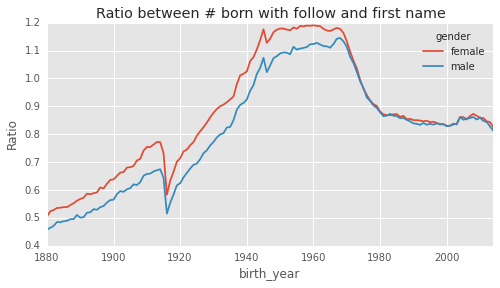

In [17]:
name_type_ratio = (yearly_births['follow'] / yearly_births['first'])
ax = name_type_ratio.plot(figsize=(8, 4))
ax.set_ylabel('Ratio')
ax.set_title("Ratio between # born with follow and first name")

## 2. Mortality rates 

The life expectancy is given as the number of people surviving from a cohort of 100,000.

In [18]:
survival = pd.read_csv('data/cbs_life_expectancy.csv', delimiter=';', skiprows=4, 
                       names=['age', 'birth_year', 'gender', 'amount'], skipfooter=1)
survival.head()

/usr/local/lib/python2.7/dist-packages/pandas/io/parsers.py:648: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skip_footer; you can avoid this warning by specifying engine='python'.
  ParserWarning)


,age,birth_year,gender,amount
0,0 jaar,1850,Mannen,100000
1,0 jaar,1850,Vrouwen,100000
2,0 jaar,1851,Mannen,100000
3,0 jaar,1851,Vrouwen,100000
4,0 jaar,1852,Mannen,100000


Convert strings to floats and get rid of all the Dutch words.

In [19]:
survival['age'] = survival.age.str.split(' ').apply(lambda x: float(x[0]))
survival['gender'] = survival.gender.map({'Mannen': 'male', 'Vrouwen': 'female'})
survival.ix[(survival.amount == '.'), 'amount'] = None
survival['survival_rate'] = survival['amount'].astype(np.float) / 100000.
survival.drop('amount', axis=1, inplace=True)
survival.sort(['birth_year', 'gender', 'age'], inplace=True)
survival.head()

,age,birth_year,gender,survival_rate
1,0,1850,female,1.00000
423,1,1850,female,0.88455
845,2,1850,female,0.80731
1267,3,1850,female,0.76907
1689,4,1850,female,0.75025


Not all years and ages have survival rates. To fill in the blanks, we'll:
<li> use forward filling to use the last known survival rate for an age (naively assuming that the survival rate doesn't improve over time); </li>
<li> and extrapolate survival rates for ages above 99 years by setting a maximum expected age and interpolate the missing parts. </li>

This will give us more data than we actually need, but it's a nice exercise.

In [20]:
survival[survival.birth_year == 1990].tail()

,age,birth_year,gender,survival_rate
40370,95,1990,male,NaN
40792,96,1990,male,NaN
41214,97,1990,male,NaN
41636,98,1990,male,NaN
42058,99,1990,male,NaN


In [21]:
MAX_AGE = 105

def ffill_missing_years(df):
    """
    Forward fill missing years for a given age and gender by 
    taking the survival rate of the last known year.
    
    :param df: DataFrame with survival rates
    :returns Forward filled DataFrame
    """
    groupby_cols = ['gender', 'age']
    groups = df.groupby(groupby_cols)
    filled = groups.apply(ffill_group)
    # Perform an ugly hack to avoid duplicate columns.
    reindex = filled.drop(groupby_cols, axis=1).reset_index(groupby_cols)
    return reindex


def ffill_group(g):
    """
    Forward fill a group using birth years.
    
    :param g: DataFrameGroupBy object for an age & gender 
    :returns Forward filled DataFrameGroupBy object
    """
    reindex_g = g.set_index('birth_year')
    filled_g = reindex_g.fillna(method='ffill')
    return filled_g.reset_index()


def extrapolate_age_survival_rate(df, max_age=MAX_AGE, method='quadratic'):
    """
    Extrapolate survival rates up to a maximum age by assuming that
    the survival rate is 0 at the maximum age and interpolating between 
    the last known value and the maximum age.
    
    Note: negative rates return by interpolation are set to 0.
    
    :param df: DataFrame with survival rates
    :param max_age: Maximum age to extrapolate to
    :param method: Method to interpolate with (see pd.Series.interpolate)
    :returns DataFrame with extrapolated survival rates
    """
    new_axis = range(0, max_age + 1)
    groupby_cols = ['gender', 'birth_year']
    groups = df.groupby(groupby_cols)
    age_fcn = lambda x: extrapolate_col(x, 'age', new_axis, 0, method)
    extrapolated = groups.apply(age_fcn)
    extrapolated.ix[extrapolated.survival_rate < 0, 'survival_rate'] = 0
    # Perform an ugly hack to avoid duplicate columns.
    reindexed = extrapolated.drop(groupby_cols, axis=1).reset_index(groupby_cols)
    return reindexed


def extrapolate_col(df, col, extrapolate_axis, max_value, method):
    """
    Extrapolate a column by setting a maximum value as the last value
    and interpolating between the last non-NaN value and the last value. 
    
    :param df: DataFrame
    :param col: Column to interpolate
    :param extrapolate_axis: Axis to extrapolate with
    :param max_value: Maximum value to set
    :param method: Method to use for interpolating
    :returns DataFrame with extrapolated data
    """
    reindex_df = df.set_index(col).reindex(extrapolate_axis)
    reindex_df.ix[max(extrapolate_axis)] = max_value
    interpolate_func = lambda x: pd.Series.interpolate(x, method=method)
    interpolated_df = reindex_df.apply(interpolate_func)
    return interpolated_df.reset_index()

In [22]:
filled_survival = ffill_missing_years(survival)
extrapolated_survival = extrapolate_age_survival_rate(filled_survival, method='linear')

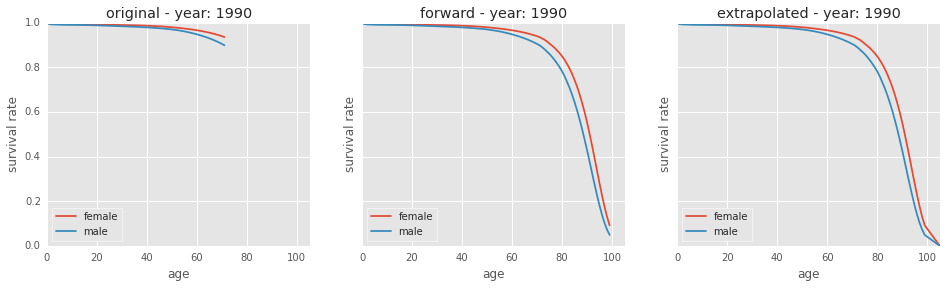

In [23]:
DEMO_YEAR = 1990
def get_yearly_data(df, year):
    """
    Get yearly data and pivot.
    
    :param df: DataFrame
    :param year: Target year
    :returns Pivoted DataFrame with data from year
    """
    temp = df[df.birth_year == year]
    data = temp.pivot(columns='gender', index='age', 
                      values='survival_rate')
    return data

year_original = get_yearly_data(survival, DEMO_YEAR)
year_filled = get_yearly_data(filled_survival, DEMO_YEAR)
year_extrapolated = get_yearly_data(extrapolated_survival, DEMO_YEAR)

fig, ax = plt.subplots(1, 3, figsize=(16, 4), sharex=True, sharey=True)

title_suffix = ' - year: ' + str(DEMO_YEAR)
year_original.plot(ax=ax[0], title='original' + title_suffix)
year_filled.plot(ax=ax[1], title='forward' + title_suffix)
year_extrapolated.plot(ax=ax[2], title='extrapolated' + title_suffix)
for current_ax in ax:
    current_ax.set_ylabel('survival rate')
    current_ax.legend(loc='lower left', frameon=True)

The plots above show that the original data missed quite some survival rates. Forward filling filled in all the blanks up to 99 years, extrapolation fixed the rest of the curve. There are probably better candidates than linear interpolation, but it works good enough and won't lead to unexpected results as can be obtained for e.g. quadratic interpolation as the plot below on the right shows for ages above 99 years.

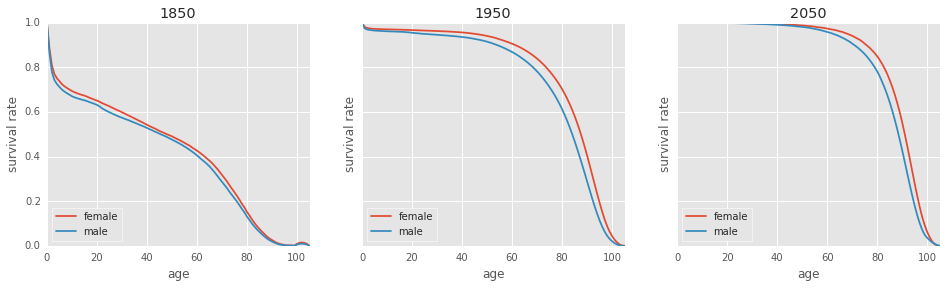

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4), sharex=True, sharey=True)
quadratic_extrapolated = extrapolate_age_survival_rate(filled_survival, method='quadratic')

for i_plot, year in enumerate([1850, 1950, 2050]):
    get_yearly_data(quadratic_extrapolated, year).plot(ax=ax[i_plot], title=str(year))
    ax[i_plot].set_ylabel('survival rate')
    ax[i_plot].legend(loc='lower left', frameon=True)

## 3. Combining births and survival rates 

With data on how many people were born in a year and on how many are expected to survive up to a given age, we'll have all the data we need. Combining these datasets will given the number of people still alive in a year for a given name, gender and name type.

First, for all years get rates on how likely it is up to survive up to a given year.

In [25]:
TARGET_YEAR = 2014
assert (extrapolated_survival.birth_year == TARGET_YEAR).any(), 'Invalid year'
is_alive_in_year = (extrapolated_survival.age + 
                    extrapolated_survival.birth_year == TARGET_YEAR)
year_survival = extrapolated_survival[is_alive_in_year]

In [26]:
year_survival.head()

,gender,birth_year,age,survival_rate
105,female,1909,105,0.000000
104,female,1910,104,0.002905
103,female,1911,103,0.005980
102,female,1912,102,0.009320
101,female,1913,101,0.013847


Combine this with the data on the births to get the yearly expected number of people born and still alive in the given year.

In [27]:
births.head()

,birth_year,gender,n_born,name,name_type
0,1880,female,0.00,Aaf,first
1,1880,female,9.10,Aaffien,first
2,1880,female,126.69,Aafje,first
3,1880,female,115.51,Aafke,first
4,1880,female,182.58,Aagje,first


In [28]:
name_survival = pd.merge(births, year_survival, on=['gender', 'birth_year'])
name_survival['n_born_and_alive'] = name_survival.n_born * name_survival.survival_rate
name_survival[(name_survival.name == 'Anne') & (name_survival.birth_year == 1970)]

,birth_year,gender,n_born,name,name_type,age,survival_rate,n_born_and_alive
1712301,1970,female,179,Anne,first,44,0.97173,173.93967
1717883,1970,female,307,Anne,follow,44,0.97173,298.32111
1721798,1970,female,486,Anne,total,44,0.97173,472.26078
1727991,1970,male,149,Anne,first,44,0.95837,142.79713
1732207,1970,male,154,Anne,follow,44,0.95837,147.58898
1735456,1970,male,303,Anne,total,44,0.95837,290.38611


Aggregate stats for both genders.

In [29]:
name_survival = append_agg(name_survival, ['birth_year', 'name', 
                                           'name_type', 'age'],
                           ['n_born', 'survival_rate', 'n_born_and_alive'],
                           'gender', 'any',
                           {'n_born': 'sum', 'survival_rate': 'mean', 
                            'n_born_and_alive': 'sum'})

In [30]:
name_survival[(name_survival.name == 'Anne') & (name_survival.birth_year == 1970)]

,age,birth_year,gender,n_born,n_born_and_alive,name,name_type,survival_rate
1712301,44,1970,female,179,173.93967,Anne,first,0.97173
1717883,44,1970,female,307,298.32111,Anne,follow,0.97173
1721798,44,1970,female,486,472.26078,Anne,total,0.97173
1727991,44,1970,male,149,142.79713,Anne,first,0.95837
1732207,44,1970,male,154,147.58898,Anne,follow,0.95837
1735456,44,1970,male,303,290.38611,Anne,total,0.95837
4575773,44,1970,any,328,316.73680,Anne,first,0.96505
4575774,44,1970,any,461,445.91009,Anne,follow,0.96505
4575775,44,1970,any,789,762.64689,Anne,total,0.96505


In [31]:
name_survival.groupby(['gender', 'name_type']).n_born_and_alive.sum()

gender  name_type
any     first        14563412.441263
        follow       14253382.466510
        total        28816794.907772
female  first         7242309.842184
        follow        7223969.460785
        total        14466279.302972
male    first         7321102.599078
        follow        7029413.005724
        total        14350515.604801
Name: n_born_and_alive, dtype: float64

In [32]:
name_survival.groupby(['gender', 'name_type']).n_born.sum()

gender  name_type
any     first        19290907.950007
        follow       18002324.600004
        total        37293232.550007
female  first         9308774.520002
        follow        8943597.780000
        total        18252372.300003
male    first         9982133.430001
        follow        9058726.820000
        total        19040860.250003
Name: n_born, dtype: float64

In [33]:
name_survival['n_dead'] = name_survival.n_born - name_survival.n_born_and_alive
out_path = 'out/name_survival_{year}.csv'.format(year=TARGET_YEAR)
name_survival.to_csv(out_path, index=False, encoding='utf-8')

## 4. Plots 

### Ideas:
<li> Total deaths per name
<li> Cumulative deaths vs cumulative born